# Basic example cytometry workflow

Welcome to `cytoflow`!  I'm glad you're here.  The following is a heavily commented workflow for importing a few tubes of cytometry data and doing some (very) basic analysis.  The goal is to give you not only a taste of using the library for interactive work, but also some insight into the rationale for the way it's designed the way it is and the way it differs from existing projects.

`cytoflow`'s goal is to enable *quantitative, reproducible* cytometry analysis.  Reproducibility between cytometry experiments is poor, due in part to differences in analysis between operators; but if all your analysis is in a `Jupyter` notebook (like this one!), then sharing and reuse of workflows is much easier.

Let's look at a very basic experiment, containing only two tubes.  These two tubes contain cells that are expressing fluorescent proteins as the read-out of some cell state.  We'll assume that these two tubes are identical, except that one has been induced with 1 µM of the small molecule inducer Doxycycline (aka 'Dox') and the other tube has been induced with 10 µM Dox.

---

Start by setting up Jupyter's plotting interface, then import the `cytoflow` module.

In [1]:
%matplotlib inline

import cytoflow as flow

The central data structure in `cytoflow` is the `Experiment`, which is basically a `pandas.DataFrame` containing the events; its associated metadata (experimental conditions and the like); and some methods to manipulate them.

You usually create an `Experiment` using an instance of the `ImportOp` class.  Start by defining two tubes, including their experimental conditions (ie, how much Dox is in each); then give those tubes, and a `dict` specifying the experimental conditions' names and types, to `ImportOp`.  Call the `apply()` function to get back the `Experiment` with all the data in it.

In [2]:
tube1 = flow.Tube(file = 'data/RFP_Well_A3.fcs',
                  conditions = {'Dox' : 10.0})
tube2 = flow.Tube(file='data/CFP_Well_A4.fcs',
                  conditions = {'Dox' : 1.0})

import_op = flow.ImportOp(conditions = {'Dox' : 'float'},
                          tubes = [tube1, tube2])

ex = import_op.apply()

Once you have an `Experiment` instance, this is the last time you should ever think about tubes or wells.  Rather, think of your experiment as a very large set of single-cell measurements, each of which has some metadata associated with it; in this case, how much Dox the cell was exposed to.  `cytoflow` helps you focus your analysis on how those measurements change as the experimental conditions change, without worrying about what cells were in what tube.

---
Let's have a quick look at one of the fluorescence channels, `Y2-A`.  Instantiate a `HistogramView` and tell it which channel we're looking at, then call `plot` and pass it the experiment containing the data.  Remember, this is not a single tube, but rather all the data in the `Experiment`.

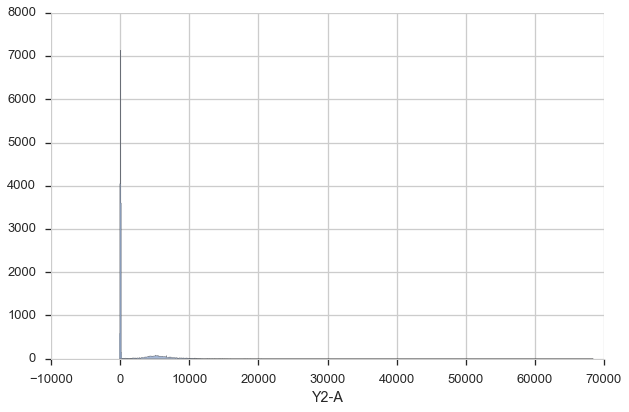

In [3]:
hist = flow.HistogramView()
hist.name = "Histogram view, by color"
hist.channel = 'Y2-A'
hist.plot(ex)

Hmmm.  This plot is hard to interpret because most of the data is clustered around 0, in the linear range of the detector's response.  Let's re-plot using a different scale.  My favorite is `logicle`, which has a linear response around 0 and a log range elsewhere.  We specify the plot scale by setting the `scale` attribute of `HistogramView` to `logicle`; other options are `log` and `linear`.

The cell below also demonstrates a different way to parameterize the `HistogramView` instance, by passing parameters to the constructor instead of setting the values of the instance's attributes after we make it.  Either way is correct.

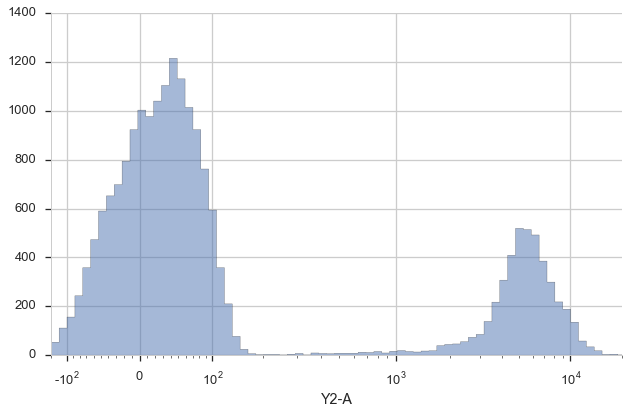

In [4]:
hist = flow.HistogramView(name = "Histogram view, by color",
                          channel = 'Y2-A',
                          scale = 'logicle')
hist.plot(ex)

Ah, much better.  There is clearly a population of cells around 0 and a population of cells around about 5000.  But!  This is the entire `Experiment` -- is is one of the populations from the low-Dox tube and the other population from the high-Dox tube?

Let's see if the histogram is different for the two different concentrations of inducer. `CytoFlow`'s plotting takes inspiration from Trellis plots (eg the lattice package in R): to split the data into subsets, you tell the plotting module which metadata "facet" you want to plot in the X, Y and color (hue) axes.

This time, we tell `HistogramView` to make a separate plot for each different value of Dox and stack them on top of eachother by saying `yfacet = 'Dox'`; if we wanted the plots side-by-side, we would have said `xfacet = 'Dox'`.  

Also note that this time, we don't keep around the `HistogramView` object; if we don't need to re-use it, we can just call `plot` right after the constructor.

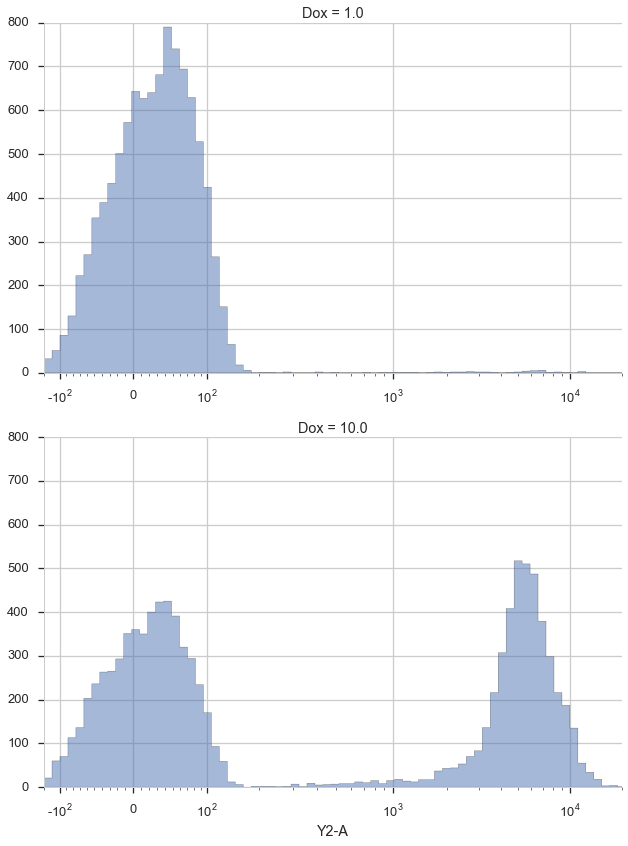

In [5]:
flow.HistogramView(name = "Histogram view, by color",
                   channel = 'Y2-A',
                   scale = 'logicle',
                   yfacet = 'Dox').plot(ex)

Indeed, the two tubes have dramatically different histograms.  We could also plot them on top of eachother with different colors, by using `huefacet` instead of `yfacet`.

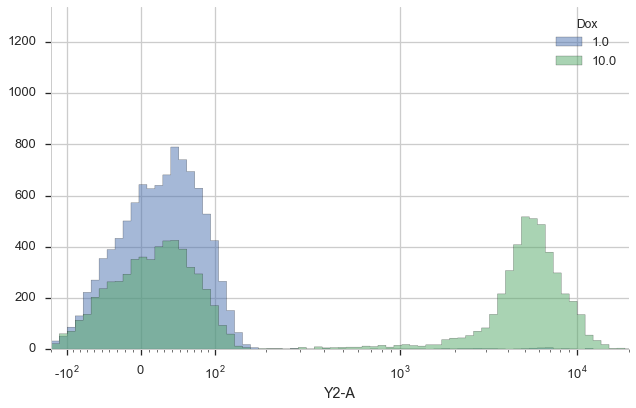

In [6]:
flow.HistogramView(name = "Histogram view",
                   channel = "Y2-A",
                   scale = "logicle",
                   huefacet = 'Dox').plot(ex)

So, there's a clear difference between these tubes: one has a substantial population above about ~200 in the Y2-A, and the other doesn't.  What's the proportion of "high" cells?  Let's gate out the "high" population using a `ThresholdOp`.

In [7]:
thresh = flow.ThresholdOp(name = "Y2-A+",
                          channel = "Y2-A",
                          threshold = 200)

ex2 = thresh.apply(ex)

Two important things to note here: first, an `Operation` (such as `ThresholdOp`) *does not operate in place*; instead, you create a `ThresholdOp` object, then call `apply()` to run it on an `Experiment`.  The `apply()` function returns a new `Experiment`.

Second, a gate *does not remove events*; it simply *adds additional metadata* to the events already there.  You can see this if we look at the underlying `pandas.DataFrame` for `ex` and `ex2`:

In [8]:
print ex.data.head()
print "----"
print ex2.data.head()

         B1-A        B1-H          B1-W   Dox       FSC-A       FSC-H  \
0 -127.094002  257.718353 -63040.300781  10.0  459.962982  437.354553   
1  -70.234840  255.798340 -34034.042969  10.0 -267.174652  365.354553   
2  -96.471756  313.398346 -41931.687500  10.0 -201.582336  501.354553   
3   18.831570  277.669250   8514.489258  10.0  291.259888  447.029755   
4  100.882095  255.756256  51291.074219  10.0 -397.168579  354.565308   

           FSC-W      HDR-T        SSC-A        SSC-H          SSC-W  \
0  137847.578125   2.018511   840.091370   747.917847  147225.328125   
1  -95849.679688  27.451754  3476.902344  3163.917969  144038.046875   
2  -52700.828125  32.043865   480.270691   507.917877  123937.437500   
3   85399.273438  79.327492  8026.275879  6741.838867  156043.484375   
4 -146821.125000  79.731194  7453.750488   609.884277  262143.968750   

         V2-A        V2-H           V2-W         Y2-A         Y2-H  \
0   41.593452  240.153854   22701.017578   109.946274   15

In ex2, the `ThresholdOp` added a new column, named `Y2-A+`, which has the same name as the `ThresholdOp`'s `name` attribute.  It is `True` if the `Y2-A` value is greater than 200, and `False` otherwise.  The `Y2-A+` column is now a piece metadata *just like the Dox concentration* that we can use to facet the plots.  For example, the following plots different `Dox` concentrations in separate plots stacked on top of eachother (`yfacet = "Dox"`), and on each of these plots uses separate colors for the "low" and "high" populations (`huefacet = 'Y2-A'`):

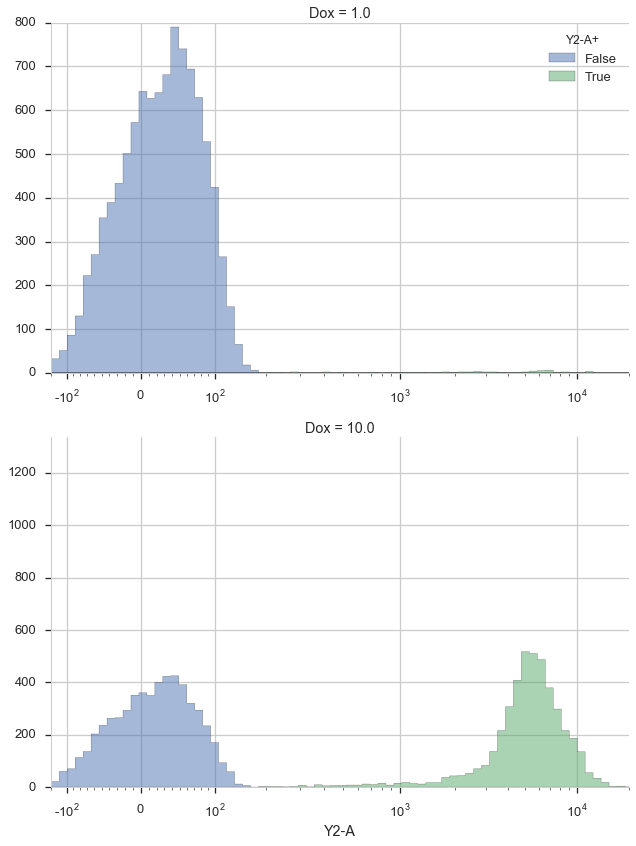

In [9]:
flow.HistogramView(name = "Histogram view",
                   channel = "Y2-A",
                   scale = "logicle",
                   yfacet = "Dox",
                   huefacet = 'Y2-A+').plot(ex2)

It's also important to note that we can still access the underlying `pandas.Dataframe`: either by looking at the `Experiment.data` attribute, or by referencing a column directly:

In [10]:
print ex2["Y2-A+"][0:10]

0    False
1     True
2    False
3    False
4    False
5    False
6     True
7    False
8     True
9    False
Name: Y2-A+, dtype: bool


Because the data is all stored in a single `pandas.Dataframe`, we can use the `pandas` API, and indeed the rest of the SciPy stack, to ask sophisticated questions of the underlying data.  For example, "how many events of each Dox concentration were above the threshold?"

In [11]:
ex2.data.groupby(['Dox', 'Y2-A+']).size()

Dox   Y2-A+
1.0   False    9946
      True       54
10.0  False    5561
      True     4439
dtype: int64

`cytoflow` can answer the same question for us using one of its statistics views.  In `cytoflow`, a *statistic* is a number that summarizes a population; one of the key features
of `cytoflow` is that it makes it easy to see how these summary statistics change as your experimental conditions change.

Several operations add statistics to an experiment; one of the most straightforward ones is `Statistic1DOp`.  It groups the experiment's data by the conditions specified in `by`, then
applies `function` to `channel` for each group.

In this case, we'll divide up the data into the subgroups `Y2-A+ == True & Dox == 1`; `Y2-A+ == True & Dox == 10`; `Y2-A+ == False & Dox == 1`; and `Y2-A+ == False & Dox == 10`.  Then, we'll apply the function `len` to the `Y2-A` channel.

In [12]:
ex3 = flow.Statistics1DOp(name = "ByDox",
                          channel = "Y2-A",
                          by = ['Y2-A+', 'Dox'],
                          function = len).apply(ex2)

Now we can look at the new statistic: `Experiment.statistics` is a dictionary whose keys are tuples and whose values are the computed statistics (stored as `MultiIndex`ed `pandas.Series`).  The first element in the tuple is the name of the operation that added it, and the second is defined by that operation.  In this case, it's `len`, the name of the function.

In [13]:
ex3.statistics[("ByDox", "len")]

Y2-A+  Dox 
False  1.0     9946.0
       10.0    5561.0
True   1.0       54.0
       10.0    4439.0
Name: Y2-A, dtype: float64

We can also plot statistics using one of the various statistics views, such as `BarChartView`.

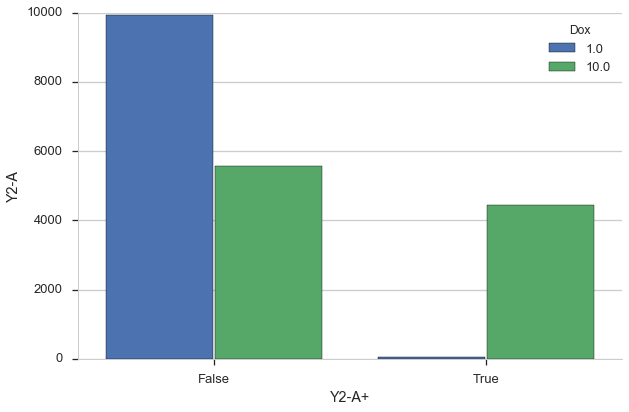

In [14]:
flow.BarChartView(statistic = ("ByDox", "len"),
                  variable = "Y2-A+",
                  huefacet = 'Dox').plot(ex3)

Statistics are important enough that they get an entire notebook of examples; please see `Statistics.ipynb` for a more in-depth exploration.

I hope this makes the semantics of the `cytoflow` package clear.  This was a pretty simplistic toy analysis; for more sophisticated examples, see the other accompanying Jupyter notebooks.